In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import utilsDIPS as udips
import modelDIPS as mdips

Using TensorFlow backend.


In [2]:
# step_name = 'r11004_RT_ConfigHTT_eff95flat_NewMoU_InIn_sf2_pt4_v1'
# step_name = 'r11004_RT_ConfigHTT_eff95flat_NewMoU_OutOut_sf2_pt4_v1'
# step_name = 'r11004_RT_ConfigHTT_eff95flat_MoU2_sf2_pt4_v2'
# step_name = 'r11002_RT_ConfigHTT_eff95flat_TDR2in_sf2_pt4_v1'
# step_name = 'r11002_ConfigHTT_eff95flat_NoPix_In_sf2_pt4_v1'
# step_name = 'r11002_ConfigHTT_eff95flat_MoU_L1_InIn_sf2_pt4_v1'
# step_name = 'r11002_eff95flat_PIX4L2_InIn_sf2_pt4_v1'
# step_name = 'r11004_RT_ConfigHTT_eff100flat_v1_BTAGSTREAM'
# step_name = 'r11002_MOU2in_L1TrkSimBasedWithOffPtDep_wFake'
step_name = 'r11002NOPIX_L1TrkSimBasedWithOffPtDep_wFake'

In [3]:
LOC='/gpfs/slac/atlas/fs1/d/rafaeltl/public/L1BTag/ml_datasets/'
file_path = LOC+'/ttbar_' + step_name + '_BTAGSTREAM_gathered.h5'

In [4]:
dataset = udips.open_dataset(file_path)

jet_E
jet_eta
jet_flav
jet_ip3d_llr
jet_ntrks
jet_phi
jet_pt
jet_weights
trk_chi2
trk_dr
trk_eta
trk_ip3d_d0
trk_ip3d_sig_d0
trk_ip3d_sig_z0
trk_ip3d_z0
trk_phi
trk_pt
trk_ptfrac


In [5]:
training_vars = ["trk_dr", "trk_ptfrac", 
                 "trk_ip3d_sig_d0", "trk_ip3d_sig_z0", 
                 "trk_ip3d_d0", "trk_ip3d_z0"]
# training_vars = ["trk_dr", "trk_ptfrac", "trk_ip3d_sig_d0", "trk_ip3d_sig_z0"]
# training_vars = ["trk_ip3d_sig_d0", "trk_ip3d_sig_z0"]
vars_tolog = ["trk_ptfrac", "trk_dr"]

In [6]:
data_matrix,mean,std = udips.make_data_matrix(dataset,track_vars_to_train=training_vars, 
                                        log_transform_list=vars_tolog, max_tracks=20, max_dr = 10.2)

Max number of tracks per jet to train with 20
Total number of jets 1152355


In [7]:
#select only b or light jets
b_or_light_filter, data_matrix_filtered, data_flavor_filtered, data_weight_filtered, data_y_filtered = udips.filter_b_or_light(dataset,data_matrix)

In [8]:
for this_arr in (b_or_light_filter, data_matrix_filtered, data_flavor_filtered, data_weight_filtered, data_y_filtered):
    print(this_arr.shape)

(1152355,)
(1030432, 20, 6)
(1030432,)
(1030432,)
(1030432,)


In [9]:
import importlib
importlib.reload(udips)

<module 'utilsDIPS' from '/gpfs/slac/atlas/fs1/u/rafaeltl/L1BTagATLAS/training/rnnip/l1dips/notebooks/utilsDIPS.py'>

In [10]:
jet_inputs = ["jet_pt", "jet_eta"]
X_jets, X_jets_filtered = udips.make_jet_matrix(dataset, jet_inputs, b_or_light_filter, do_trkvec_vars=False)

In [11]:
X_jets.shape

(1152355, 2)

In [12]:
## do jet cuts?
do_jet_cuts = True
jet_eta_cut = 2.8
jet_pt_cut = 40000.

ind_pt = dataset["jet_pt"][b_or_light_filter] > jet_pt_cut
ind_eta = np.abs(dataset["jet_eta"])[b_or_light_filter] < jet_eta_cut
sel_index = ind_pt & ind_eta

if do_jet_cuts:
    data_matrix_filtered = data_matrix_filtered[ sel_index , :, : ]
    data_y_filtered = data_y_filtered[sel_index]
    data_weight_filtered = data_weight_filtered[sel_index]
    X_jets_filtered = X_jets_filtered[sel_index]

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test, w_train, w_test, J_train, J_test = train_test_split(
    data_matrix_filtered,
    data_y_filtered,
    data_weight_filtered, 
    X_jets_filtered, 
    test_size=0.30, random_state=42)

In [15]:
do_jet_inputs = True

In [16]:
import importlib
importlib.reload(mdips)

<module 'modelDIPS' from '/gpfs/slac/atlas/fs1/u/rafaeltl/L1BTagATLAS/training/rnnip/l1dips/notebooks/modelDIPS.py'>

In [17]:
model = mdips.make_dips_model( [data_matrix_filtered.shape[1], data_matrix_filtered.shape[2]] ,
                              [50,50,50], [50,50], 
                              do_jet_inputs,
                              X_jets_filtered.shape[1])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
track_inputs (InputLayer)       (None, 20, 6)        0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 20, 6)        0           track_inputs[0][0]               
__________________________________________________________________________________________________
Phi0_Dense (TimeDistributed)    (None, 20, 50)       350         masking_1[0][0]                  
__________________________________________________________________________________________________
Phi1_Dense (TimeDistributed)    (None, 20, 50)       2550        Phi0_Dense[0][0]                 
____________________________________________________________________________________________

Train on 335925 samples, validate on 37325 samples
Epoch 1/100
335925/335925 [==============================] - 19s 57us/step - loss: 0.5779 - accuracy: 0.6658 - val_loss: 0.5514 - val_accuracy: 0.6809

Epoch 00001: val_loss improved from inf to 0.55145, saving model to models_and_weights/dips_weight_r11002NOPIX_L1TrkSimBasedWithOffPtDep_wFake.h5
Epoch 2/100
335925/335925 [==============================] - 18s 54us/step - loss: 0.5507 - accuracy: 0.6789 - val_loss: 0.5484 - val_accuracy: 0.6852

Epoch 00002: val_loss improved from 0.55145 to 0.54838, saving model to models_and_weights/dips_weight_r11002NOPIX_L1TrkSimBasedWithOffPtDep_wFake.h5
Epoch 3/100
335925/335925 [==============================] - 17s 50us/step - loss: 0.5471 - accuracy: 0.6819 - val_loss: 0.5451 - val_accuracy: 0.6868

Epoch 00003: val_loss improved from 0.54838 to 0.54507, saving model to models_and_weights/dips_weight_r11002NOPIX_L1TrkSimBasedWithOffPtDep_wFake.h5
Epoch 4/100
335925/335925 [====================


Epoch 00032: val_loss did not improve from 0.53363
Epoch 33/100
335925/335925 [==============================] - 19s 56us/step - loss: 0.5305 - accuracy: 0.6941 - val_loss: 0.5327 - val_accuracy: 0.6915

Epoch 00033: val_loss improved from 0.53363 to 0.53273, saving model to models_and_weights/dips_weight_r11002NOPIX_L1TrkSimBasedWithOffPtDep_wFake.h5
Epoch 34/100
335925/335925 [==============================] - 18s 54us/step - loss: 0.5308 - accuracy: 0.6942 - val_loss: 0.5369 - val_accuracy: 0.6854

Epoch 00034: val_loss did not improve from 0.53273
Epoch 35/100
335925/335925 [==============================] - 18s 55us/step - loss: 0.5314 - accuracy: 0.6937 - val_loss: 0.5350 - val_accuracy: 0.6890

Epoch 00035: val_loss did not improve from 0.53273
Epoch 36/100
335925/335925 [==============================] - 18s 55us/step - loss: 0.5304 - accuracy: 0.6944 - val_loss: 0.5339 - val_accuracy: 0.6899

Epoch 00036: val_loss did not improve from 0.53273
Epoch 37/100
335925/335925 [=====

335925/335925 [==============================] - 18s 53us/step - loss: 0.5247 - accuracy: 0.6993 - val_loss: 0.5337 - val_accuracy: 0.6882

Epoch 00070: val_loss did not improve from 0.53200
Epoch 71/100
335925/335925 [==============================] - 18s 55us/step - loss: 0.5240 - accuracy: 0.6994 - val_loss: 0.5323 - val_accuracy: 0.6917

Epoch 00071: val_loss did not improve from 0.53200
Epoch 72/100
335925/335925 [==============================] - 18s 54us/step - loss: 0.5243 - accuracy: 0.6995 - val_loss: 0.5327 - val_accuracy: 0.6922

Epoch 00072: val_loss did not improve from 0.53200
Epoch 73/100
335925/335925 [==============================] - 19s 56us/step - loss: 0.5239 - accuracy: 0.6995 - val_loss: 0.5338 - val_accuracy: 0.6937

Epoch 00073: val_loss did not improve from 0.53200
Epoch 74/100
335925/335925 [==============================] - 16s 49us/step - loss: 0.5235 - accuracy: 0.6999 - val_loss: 0.5330 - val_accuracy: 0.6932

Epoch 00074: val_loss did not improve from 0

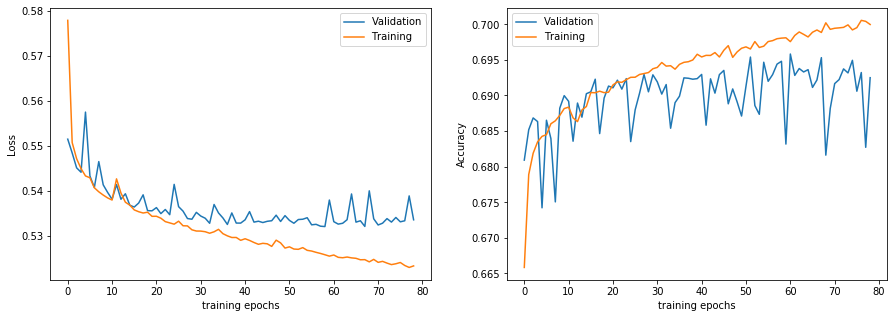

Saving json model to: models_and_weights/dips_weight_r11002NOPIX_L1TrkSimBasedWithOffPtDep_wFake_arch.json
Saving full model to: models_and_weights/dips_weight_r11002NOPIX_L1TrkSimBasedWithOffPtDep_wFake_full_model.h5


In [18]:
batch_size = 1024*2
nb_epoch = 100
patience=20
out_weight='models_and_weights/dips_weight_'+step_name+'.h5'
X_training_total = [J_train, X_train] if do_jet_inputs else X_train

history = mdips.train_model(model, X_training_total, y_train, 
                            w_train, batch_size, nb_epoch, 
                            out_weight, patience, save_checkpoint=False)

In [19]:
X_testing_total = [J_test, X_test] if do_jet_inputs else X_test
yhat_test = model.predict(X_testing_total, batch_size=batch_size, verbose=True)

159965/159965 [==============================] - 2s 15us/step


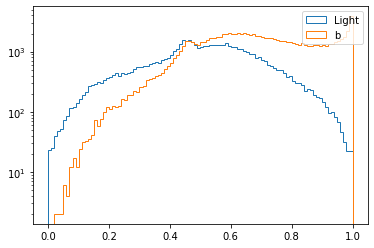

In [20]:
plt.Figure()
h_l = plt.hist(yhat_test[(y_test==0)], histtype='step', bins=100, range=(0,1), label='Light')
h_b = plt.hist(yhat_test[(y_test==1)], histtype='step', bins=100, range=(0,1), label='b')
plt.legend()
plt.yscale('log')
plt.show()

In [21]:
b_eff = ((np.add.accumulate( h_b[0][::-1] ) ) / np.sum(h_b[0]))
l_eff = ((np.add.accumulate( h_l[0][::-1] ) ) / np.sum(h_l[0]))

In [22]:
hip3d_b = np.histogram(dataset["jet_ip3d_llr"][(dataset["jet_flav"]==5) & (dataset["jet_pt"]>jet_pt_cut) & (np.abs(dataset["jet_eta"])<jet_eta_cut)], bins=100, range=(-25, 30))
hip3d_l = np.histogram(dataset["jet_ip3d_llr"][(dataset["jet_flav"]==0) & (dataset["jet_pt"]>jet_pt_cut) & (np.abs(dataset["jet_eta"])<jet_eta_cut)], bins=100, range=(-25, 30))
ip3d_b_eff = udips.get_eff_from_hist(hip3d_b)
ip3d_l_eff = udips.get_eff_from_hist(hip3d_l)

In [23]:
# b_eff_02, l_eff_02 = b_eff, l_eff
# b_eff_20202020_100100, l_eff_20202020_100100 = b_eff, l_eff
# b_eff_50505050_100100, l_eff_50505050_100100 = b_eff, l_eff
# b_eff_100100_100100, l_eff_100100_100100 = b_eff, l_eff

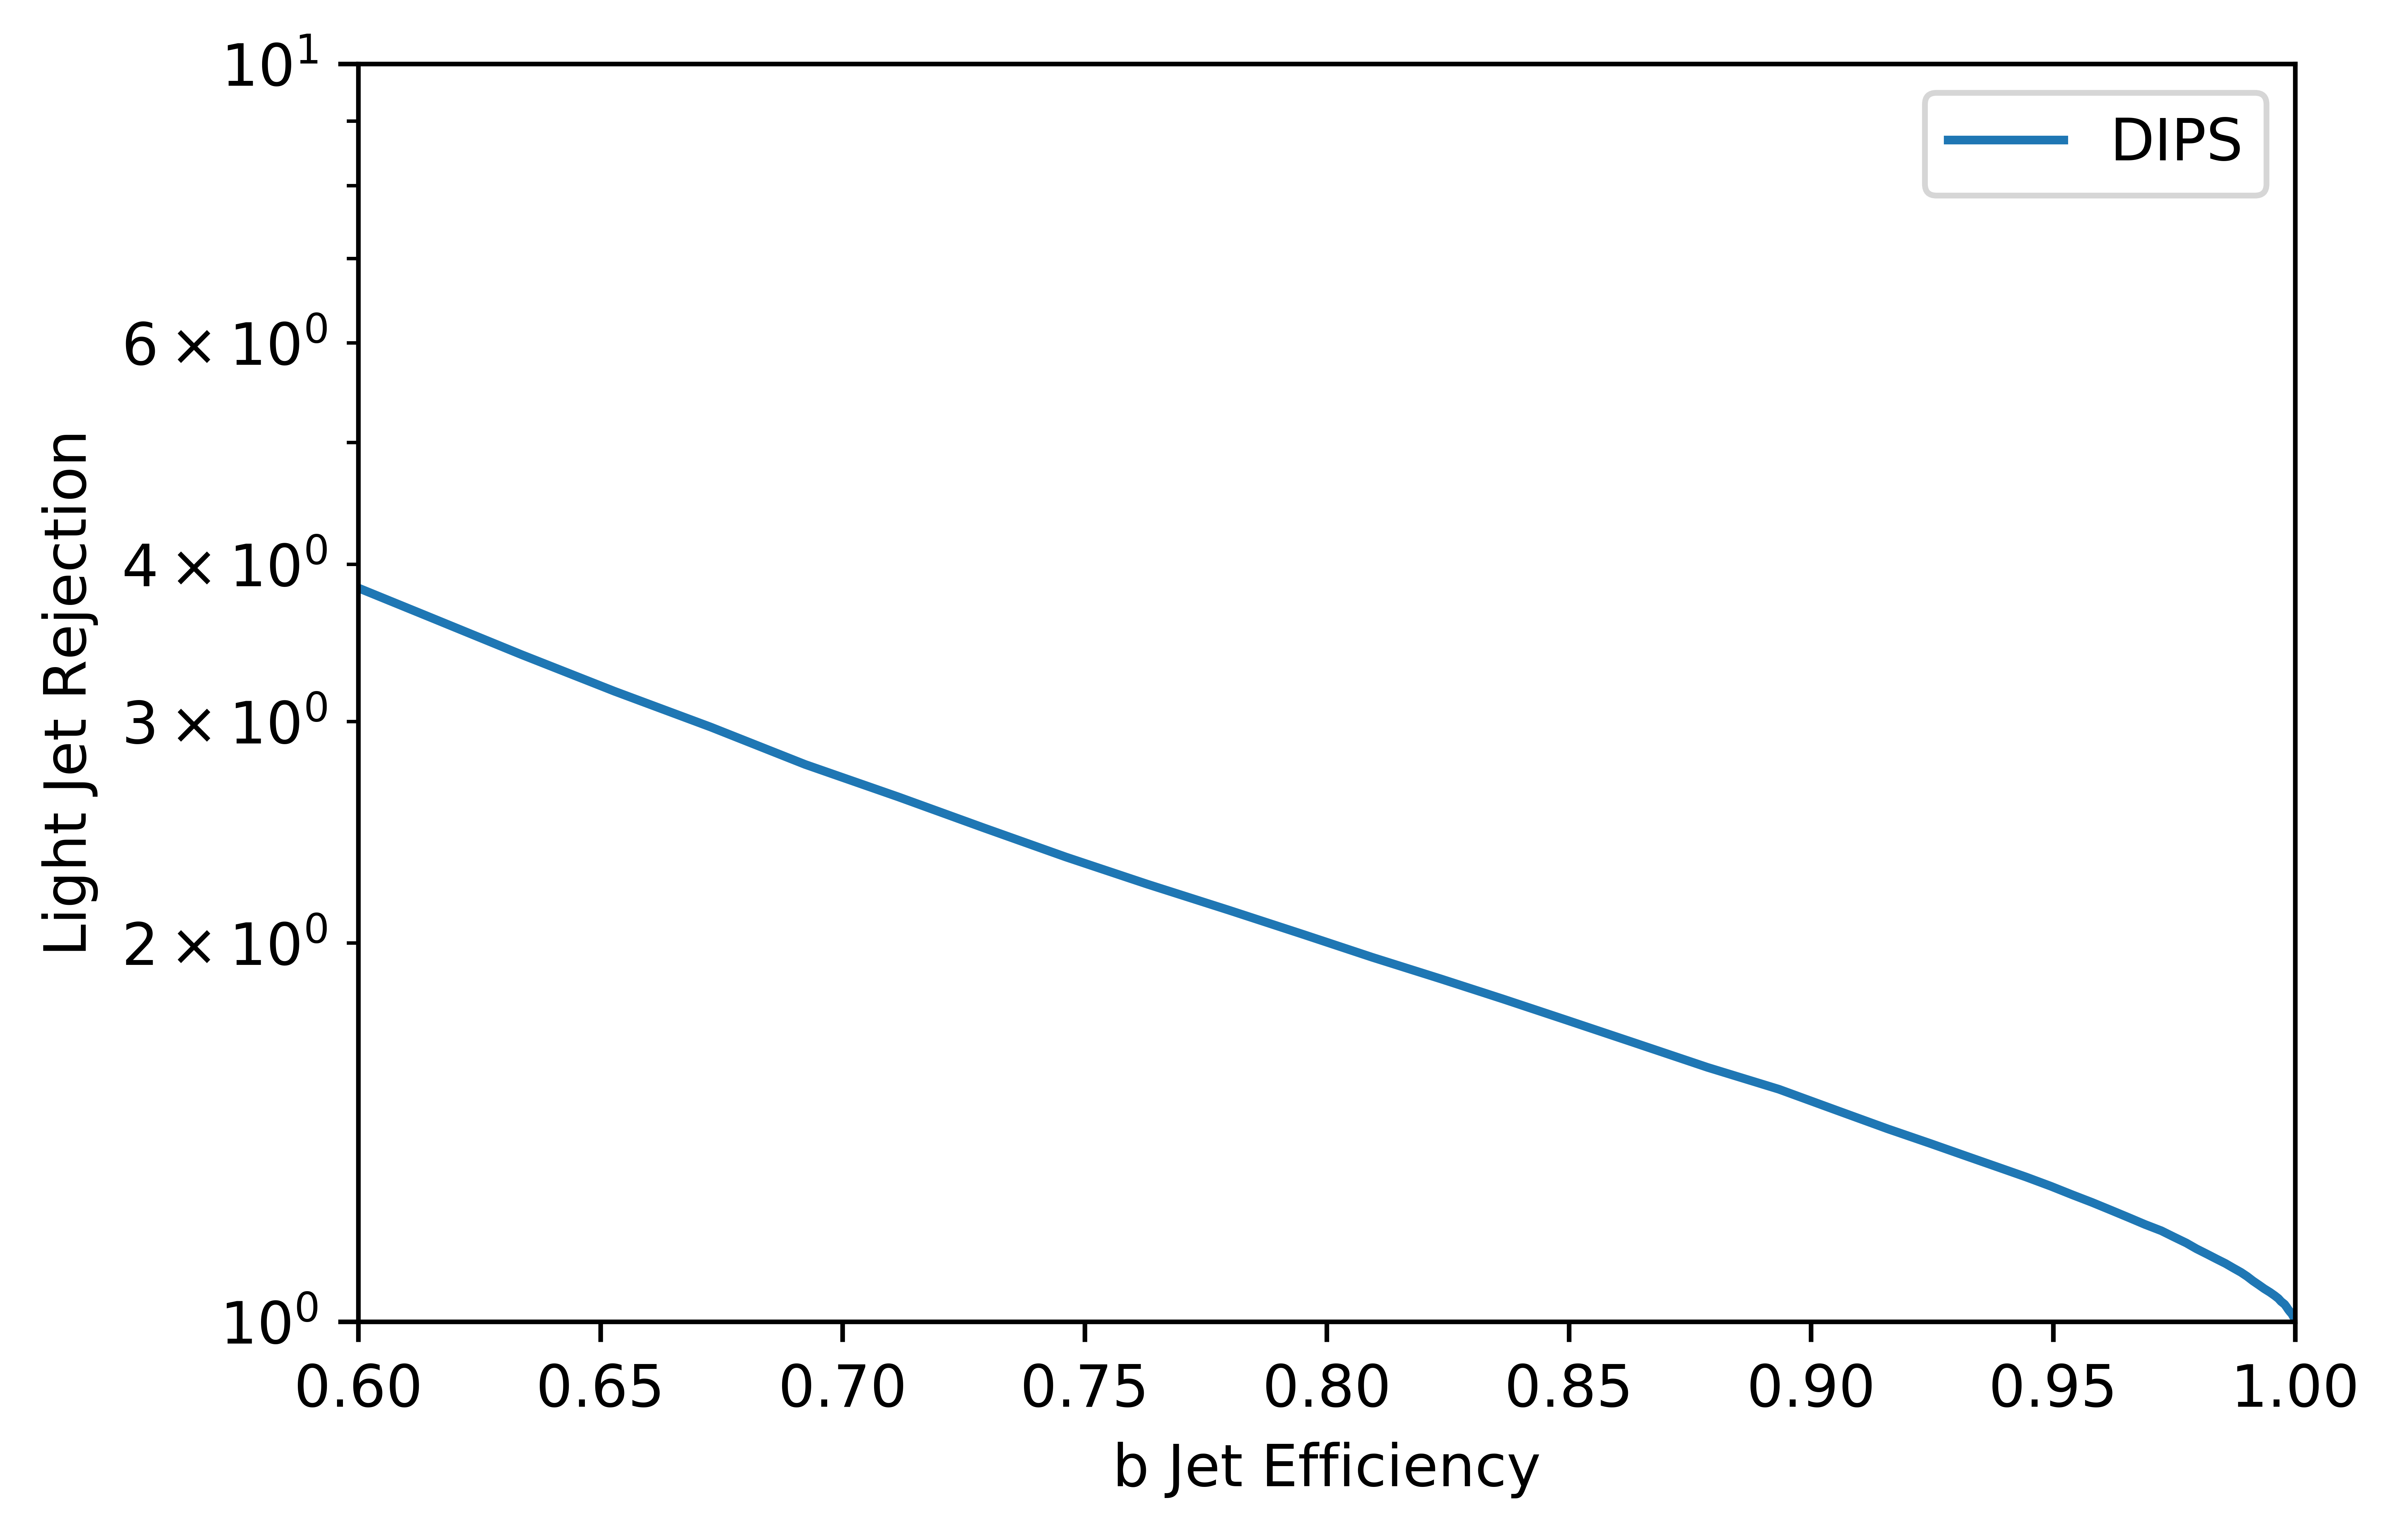

In [24]:
plt.figure(dpi=1200)

# plt.semilogy( ip3d_b_eff, 1./ip3d_l_eff, 
#              label='IP3D', linestyle='--' )

plt.semilogy( b_eff, 1./l_eff, label='DIPS' )
# plt.semilogy( b_eff_50505050_100100, 1./l_eff_50505050_100100, label='DIPS, 50505050 100100' )
# plt.semilogy( b_eff_100100_100100, 1./l_eff_100100_100100, label='DIPS, 100100 100100' )
plt.xlim(0.6, 1.0)
plt.ylim(1, 10)
plt.xlabel('b Jet Efficiency')
plt.ylabel('Light Jet Rejection')
plt.legend()
# plt.text(0.42, 850, "IP-based Deep Sets b-Tagger\nFirst Test\n10 epochs", verticalalignment='top')
# plt.savefig("DIPS_MoU_DifferentDR.pdf")
plt.show()

In [25]:
to_pred_all = [X_jets, data_matrix] if do_jet_inputs else data_matrix
pred_all = model.predict(to_pred_all, batch_size=batch_size, verbose=True)

1152355/1152355 [==============================] - 17s 15us/step


In [26]:
udips.save_important_stuff(f"dss/ds_summary_{step_name}.h5", 
                           dataset["jet_pt"], 
                           dataset["jet_eta"], 
                           dataset["jet_ip3d_llr"], 
                           pred_all, 
                           dataset["jet_flav"])